In [ ]:
# Clone the entire repo.
!git clone -l -s git://github.com/RobbieHolland/AIWire.git
%cd AIWire
!ls

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
# Import libraries 
import time
import matplotlib.pyplot as plt
import numpy as np
# Use full browser width
from IPython.core.display import display, HTML
display(HTML(""))


# (Option 1) Generate data
Run the Matlab engine to call scripts that generate data

In [3]:
# python -m ipykernel install --user --name=my-virtualenv-name
import matlab.engine

# Show data
eng_start = time.time()
eng = matlab.engine.start_matlab()
print('Engine start took', time.time() - eng_start, 'seconds')

Engine start took 9.140128135681152 seconds


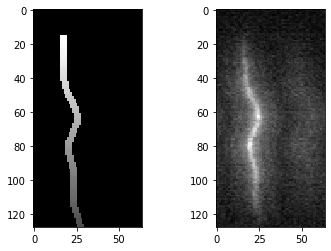

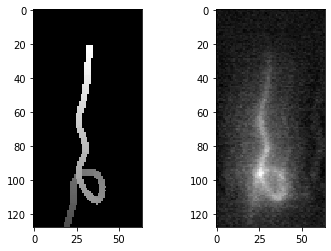

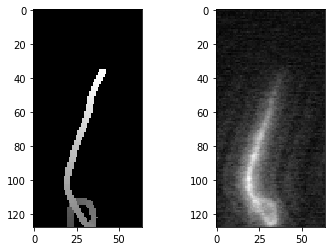

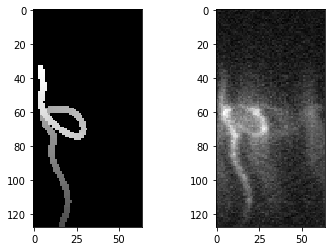

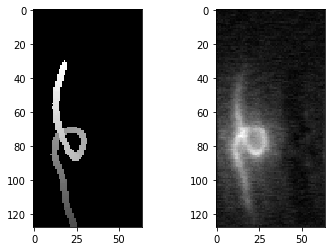

Simulation took 3.118021011352539 seconds


In [91]:
data = []

blur = 1.3
im_size = eng.cell2mat([128.0, 64.0])
sim_start = time.time()
for i in range(5):
    eng.addpath('util/')
    pts, _ = eng.gen_spline_realistic(im_size, 100.0, 0.75, nargout = 2)
    ground_truth, simulated = eng.simulate(pts, im_size, 1.3, 4.0, 1.3, 10.0, 0.2, 1, 0, nargout=2)
    
    plt.subplot(121)
    plt.imshow(ground_truth, cmap='gray')
    
    plt.subplot(122)
    plt.imshow(simulated, cmap='gray')
    plt.show()
    
# Most of the time is to set up the connection
print('Simulation took', time.time() - sim_start, 'seconds')

In [ ]:
from tqdm import tqdm

# Generate data
N = 200
X, y = [], []

for i in tqdm(range(N)):
    ground_truth, simulated = eng.simulate(blur, 15, 0, nargout=2)
    X += [simulated]
    y += [ground_truth]
    
X, y = np.array(X), np.array(y)

# (Option 2) Load data
Load data saved in a <tt>.mat</tt> file

In [2]:
from load_data import *
# X, y = load_data('/content/drive/My Drive/AIWIRE', 'dataset')
X, y = load_data('.', 'data/iteration_1_dataset')

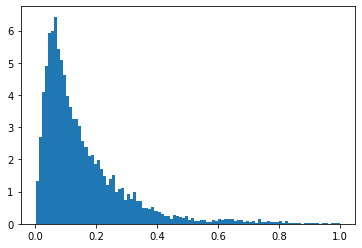

In [94]:
# Look at statistics of data
h2 = plt.hist(X[0].reshape(-1,1), bins = 100, density = True, alpha=1)

# Preprocessing
It might be advantageous to smooth the data and use simple edge detection to crudely highlight the wire.

Here we evaluate some preprocessing (but do not yet apply it to the training set)

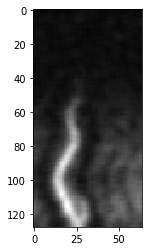

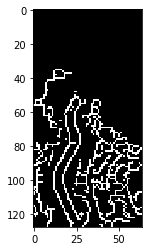

In [95]:
import cv2
ex = X[0]
kernel = np.ones((5,5),np.float32)/(5*5)
ex = cv2.filter2D(ex,-1,kernel)
plt.imshow(ex,cmap = 'gray')
plt.show()

ex = ex - np.min(ex)
ex = 255 * ex / np.max(ex)
ex = np.uint8(ex)
edges = cv2.Canny(ex,20,90)

plt.imshow(edges,cmap = 'gray')
plt.show()

# Intensity-based Segmentation
Here, we use a GMM to do a basic intensity based segmentation

In [123]:
# Segment data
from sklearn.mixture import GaussianMixture
import cv2

# The background and the wire
n_components = 2

# model=GaussianMixture(n_components=n_components, means_init=[[0], [0.6]])
# model.fit(X, y)

segmentations_laplace = []
for datum in X:
        
    # Threshold segmentation
    segmentations_threshold += [datum > 10]
    
    # Laplace filter
    lp = -cv2.Laplacian(datum, cv2.CV_64F, ksize=15)
    lp = lp - np.min(lp)
    lp = lp / np.max(lp)
    segmentations_laplace += [lp]
#     segmentations_edge += [cv2.Sobel(datum,cv2.CV_64F,1,0,ksize=5)]


## Results

Clearly, the GMM is not very good since the noise can have the same intensity as the wire.


0 8000 2000 2000 2000


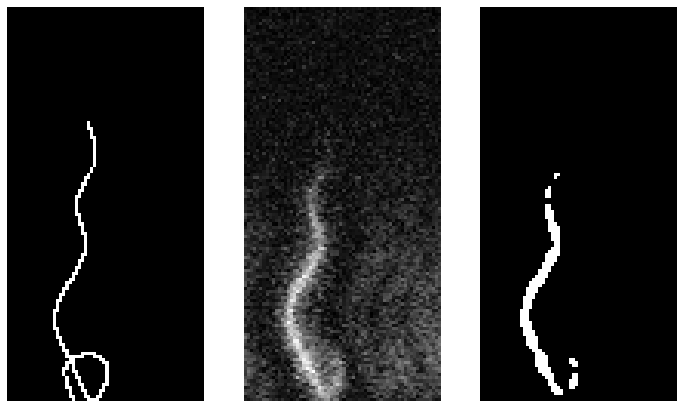

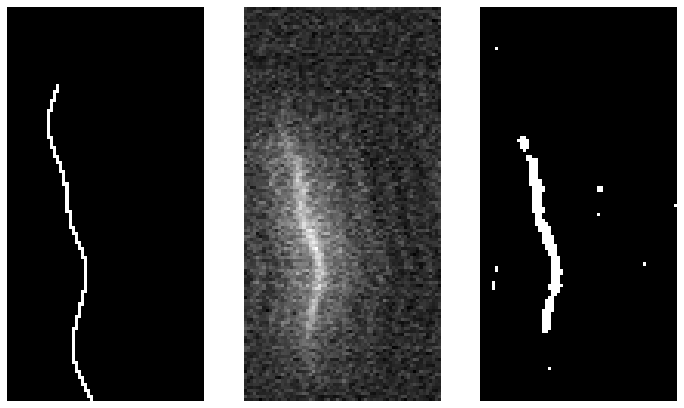

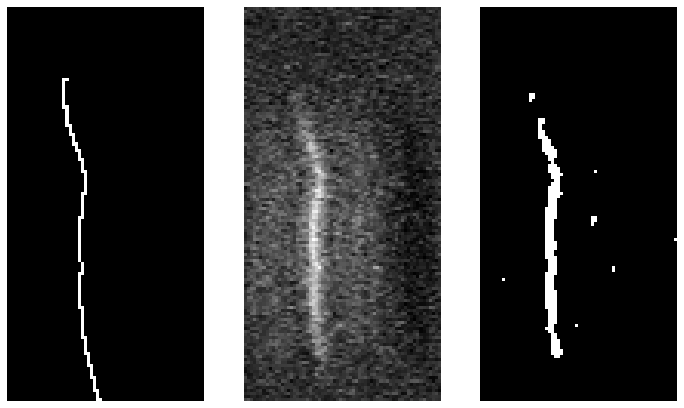

In [122]:
# Show first few segmentations
print(len(segmentations_gmm), len(segmentations_threshold), len(segmentations_edge), len(y), len(X))
for i, (seg_lap, ground_truth, simulated) in enumerate(list(zip(segmentations_laplace, y, X))[:3]):
    plt.figure(figsize=(12, 12))
    plt.subplot(131)
    plt.imshow(ground_truth, cmap='gray')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(simulated, cmap='gray')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(seg_lap, cmap='gray')
    plt.axis('off')


The Laplace filter followed by a threshold provides very accurate segmenations, with some noise

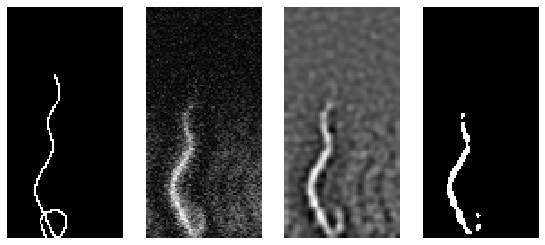

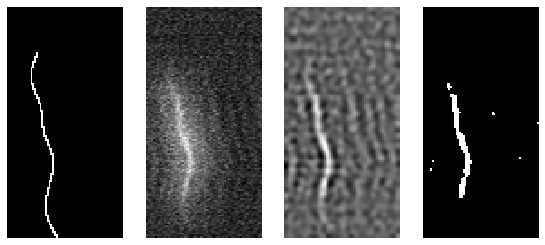

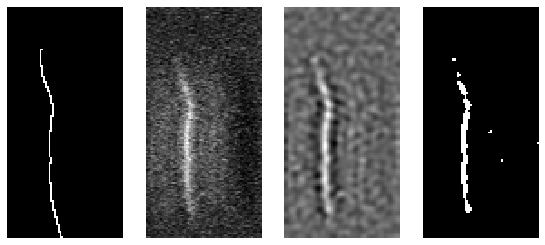

In [124]:
# Show first few segmentations
for i, (seg_edge, ground_truth, simulated) in enumerate(list(zip(segmentations_edge, y, X))[:3]):
    plt.figure(figsize=(12, 12))
    plt.subplot(151)
    plt.imshow(ground_truth, cmap='gray')
    plt.axis('off')

    plt.subplot(152)
    plt.imshow(simulated, cmap='gray')
    plt.axis('off')

    plt.subplot(153)
    plt.imshow(seg_edge, cmap='gray')
    plt.axis('off')
    
    plt.subplot(154)
    plt.imshow(seg_edge > (0.62), cmap='gray')
    plt.axis('off')
    
    plt.show()

# Random Forest Segmentation
This is the first machine learning method we are using.

### Create the dataset
Random forests predict each patch of the image by taking as input a larger, surrounding patch (to capture context)<br>
Thus, <br>
<b>y</b>: Patches of the image <br>
<b>X</b>: Larger patches centered over each <b>y</b>

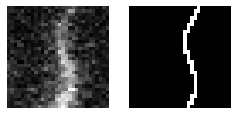

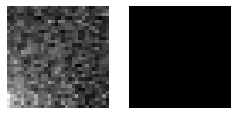

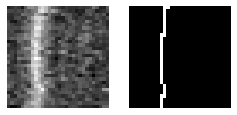

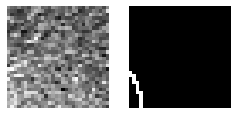

In [100]:
from random import randint

n_patches = 3000
patch_dim = 30
patches_sim, patches_gt = [], []
for i in range(n_patches):
    sample_train = X[i % len(X)]
    sample_test  = y[i % len(y)]
    tl = np.array([randint(0, sample_train.shape[i] - patch_dim - 1) for i in [0, 1]])
    patches_sim.append(sample_train[tl[0]:tl[0] + patch_dim, tl[1]:tl[1] + patch_dim])
    patches_gt.append(sample_test[tl[0]:tl[0] + patch_dim, tl[1]:tl[1] + patch_dim])

for i, (patch_sim, patch_gt) in enumerate(list(zip(patches_sim, patches_gt))[:4]):
    plt.figure(figsize=(4, 4))
    plt.subplot(121)
    plt.imshow(patch_sim, cmap='gray')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(patch_gt, cmap='gray')
    plt.axis('off')
    
patches_sim, patches_gt = np.array(patches_sim), np.array(patches_gt)
w = 3
c = patch_dim // 2
patch_labels = np.array([p[c - w:c + w, c - w:c + w] for p in patches_gt])
X_patches = np.array(patches_sim).reshape(n_patches,-1)
y_patches = np.array(patch_labels).reshape(n_patches,-1)

### Train random forest classifier

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

print('Class balance: ', np.sum(patch_labels) / np.prod(patch_labels.shape))
clf = RandomForestClassifier(max_depth=100)

X_train, X_test, y_test, y_train = train_test_split(X_patches, y_patches, test_size=0.15, random_state=0)

clf.fit(X_train, y_test)
preds = clf.predict(X_test)

Class balance:  0.0355462962962963


/Users/Robert/Documents/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Make prediction on image
To actually segment an image, we must do so patch-by-patch<br>
Then collect the patches into the final segmentation

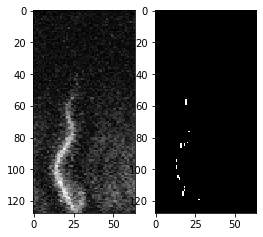

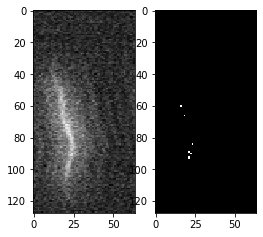

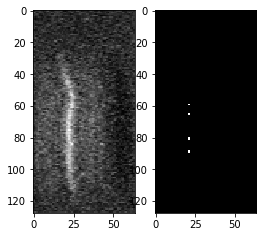

In [102]:
def rf_predict(image):
    test_sample = np.array(image)
    sample = np.pad(test_sample, patch_dim // 2 - w, mode='reflect')
    
    total_pred = np.zeros_like(test_sample)
    for i in range(w, test_sample.shape[0] - 2*w, 2 * w):
        for j in range(w, test_sample.shape[1] - 2*w, 2 * w):
            patch = sample[i:i + patch_dim, j:j + patch_dim]
            pred = clf.predict(patch.reshape(1,-1))

            total_pred[i-w:i+w,j-w:j+w] = pred.reshape(6,6)
    return total_pred

for i in range(3):
    pred = rf_predict(X[i])
    plt.figure(figsize=(4, 4))
    plt.subplot(121)
    plt.imshow(X[i], cmap='gray')
    plt.subplot(122)
    plt.imshow(pred, cmap='gray')

# Evaluation

In [3]:
import dataset
batch_size = 50
dataloaders = dataset.gen_dataloaders(X, y, batch_size, 0.2)

{'train': 1600, 'val': 400}


In [ ]:
blur = 1.3
loop_prob = 0.75
im_size = eng.cell2mat([128.0, 64.0])
sim_start = time.time()
for i in range(5):
    eng.addpath('util/')
    pts, _ = eng.gen_spline_realistic(im_size, 100.0, loop_prob, nargout = 2)
    ground_truth, simulated = eng.simulate(pts, im_size, 1.3, 4.0, 1.3, 10.0, 0.2, 1, 0, nargout=2)
    
    plt.subplot(121)
    plt.imshow(ground_truth, cmap='gray')
    
    plt.subplot(122)
    plt.imshow(simulated, cmap='gray')
    plt.show()
    
# Most of the time is to set up the connection
print('Simulation took', time.time() - sim_start, 'seconds')